In [36]:
# ライブラリのインポート
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set() 
import warnings # 実行に関係ない警告を無視
warnings.filterwarnings('ignore')
import lightgbm as lgb #LightGBM
from sklearn import datasets
from sklearn.model_selection import train_test_split # データセット分割用
from sklearn.preprocessing import LabelEncoder #ラベルエンコーダ用

In [37]:
# 特徴量可視化のためのグラフ関数
# 参考：https://mathmatical22.xyz/2020/04/12/%E3%80%90%E5%88%9D%E5%BF%83%E8%80%85%E5%90%91%E3%81%91%E3%80%91%E7%89%B9%E5%BE%B4%E9%87%8F%E9%87%8D%E8%A6%81%E5%BA%A6%E3%81%AE%E7%AE%97%E5%87%BA-lightgbm-%E3%80%90python%E3%80%91%E3%80%90%E6%A9%9F/

def plot_feature_importance(df): 
    plt.figure(dpi=500)
    n_features = len(df)                              # 特徴量数(説明変数の個数) 
    df_plot = df.sort_values('importance')            # df_importanceをプロット用に特徴量重要度を昇順ソート 
    f_importance_plot = df_plot['importance'].values  # 特徴量重要度の取得 
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values             # 特徴量の取得 
    plt.yticks(np.arange(n_features), cols_plot,fontsize=2)      # x軸,y軸の値の設定
    plt.xlabel('Feature importance')                  # x軸のタイトル
    plt.ylabel('Feature')                             # y軸のタイトル
    plt.savefig("test.png")
    plt.show()

In [38]:
# データの読み込み
data1 = pd.read_csv("Record.csv")
data2 = pd.read_csv("Client.csv")

# concatでindexを元に二つの情報を結合する
data = pd.concat([data1,data2],axis=1)

In [39]:
# データの観察

print('データのデータ数は{}、変数は{}種類です。'.format(data.shape[0], data.shape[1]))
print(data.info())

データのデータ数は100000、変数は100種類です。
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 100 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   rev_Mean          99643 non-null   float64
 1   mou_Mean          99643 non-null   float64
 2   totmrc_Mean       99643 non-null   float64
 3   da_Mean           99643 non-null   float64
 4   ovrmou_Mean       99643 non-null   float64
 5   ovrrev_Mean       99643 non-null   float64
 6   vceovr_Mean       99643 non-null   float64
 7   datovr_Mean       99643 non-null   float64
 8   roam_Mean         99643 non-null   float64
 9   change_mou        99109 non-null   float64
 10  change_rev        99109 non-null   float64
 11  drop_vce_Mean     100000 non-null  float64
 12  drop_dat_Mean     100000 non-null  float64
 13  blck_vce_Mean     100000 non-null  float64
 14  blck_dat_Mean     100000 non-null  float64
 15  unan_vce_Mean     100000 non-null  float

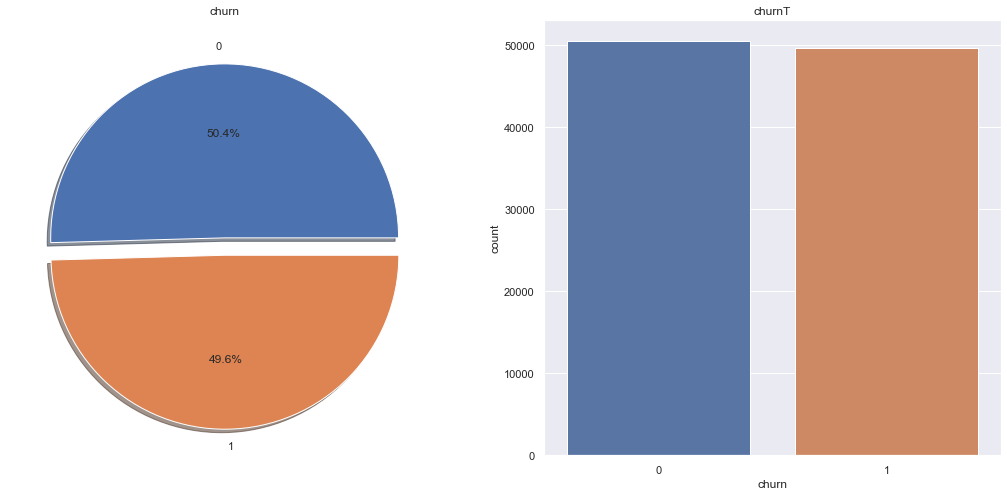

In [40]:
# 解約率の表示 1が解約
f,ax=plt.subplots(1,2,figsize=(18,8))
data['churn'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('churn')
ax[0].set_ylabel('')
sns.countplot('churn',data=data,ax=ax[1])
ax[1].set_title('churnT')
plt.show()

In [41]:
# objectコラムを見る
data.columns[data.dtypes.values == "object"]

Index(['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area',
       'dualband', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype',
       'marital', 'infobase', 'HHstatin', 'dwllsize', 'ethnic', 'kid0_2',
       'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd'],
      dtype='object')

In [42]:
# objectコラムをエンコーディング

categorical_features = ['new_cell', 'crclscod', 'asl_flag', 'prizm_social_one', 'area',
       'dualband', 'refurb_new', 'hnd_webcap', 'ownrent', 'dwlltype',
       'marital', 'infobase', 'HHstatin', 'dwllsize', 'ethnic', 'kid0_2',
       'kid3_5', 'kid6_10', 'kid11_15', 'kid16_17', 'creditcd']
for i in categorical_features:
    # Label Encoding器の作成
    le = LabelEncoder()
    # Label Encodingの適用
    x_le = le.fit_transform(data[i]) 
    data[i] = x_le



In [43]:
# 特徴量エンジニアリング、とりあえずchurnとそれ以外
y = data["churn"]
X = data.drop(["churn"],axis='columns').values
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

In [44]:
# LightGMB用データセットの作成

lgb_train = lgb.Dataset(X_train,y_train) # categorical_feature=categorical_features
lgb_eval = lgb.Dataset(X_test,y_test,reference=lgb_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 15081
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 99
[LightGBM] [Info] Start training from score 0.495812


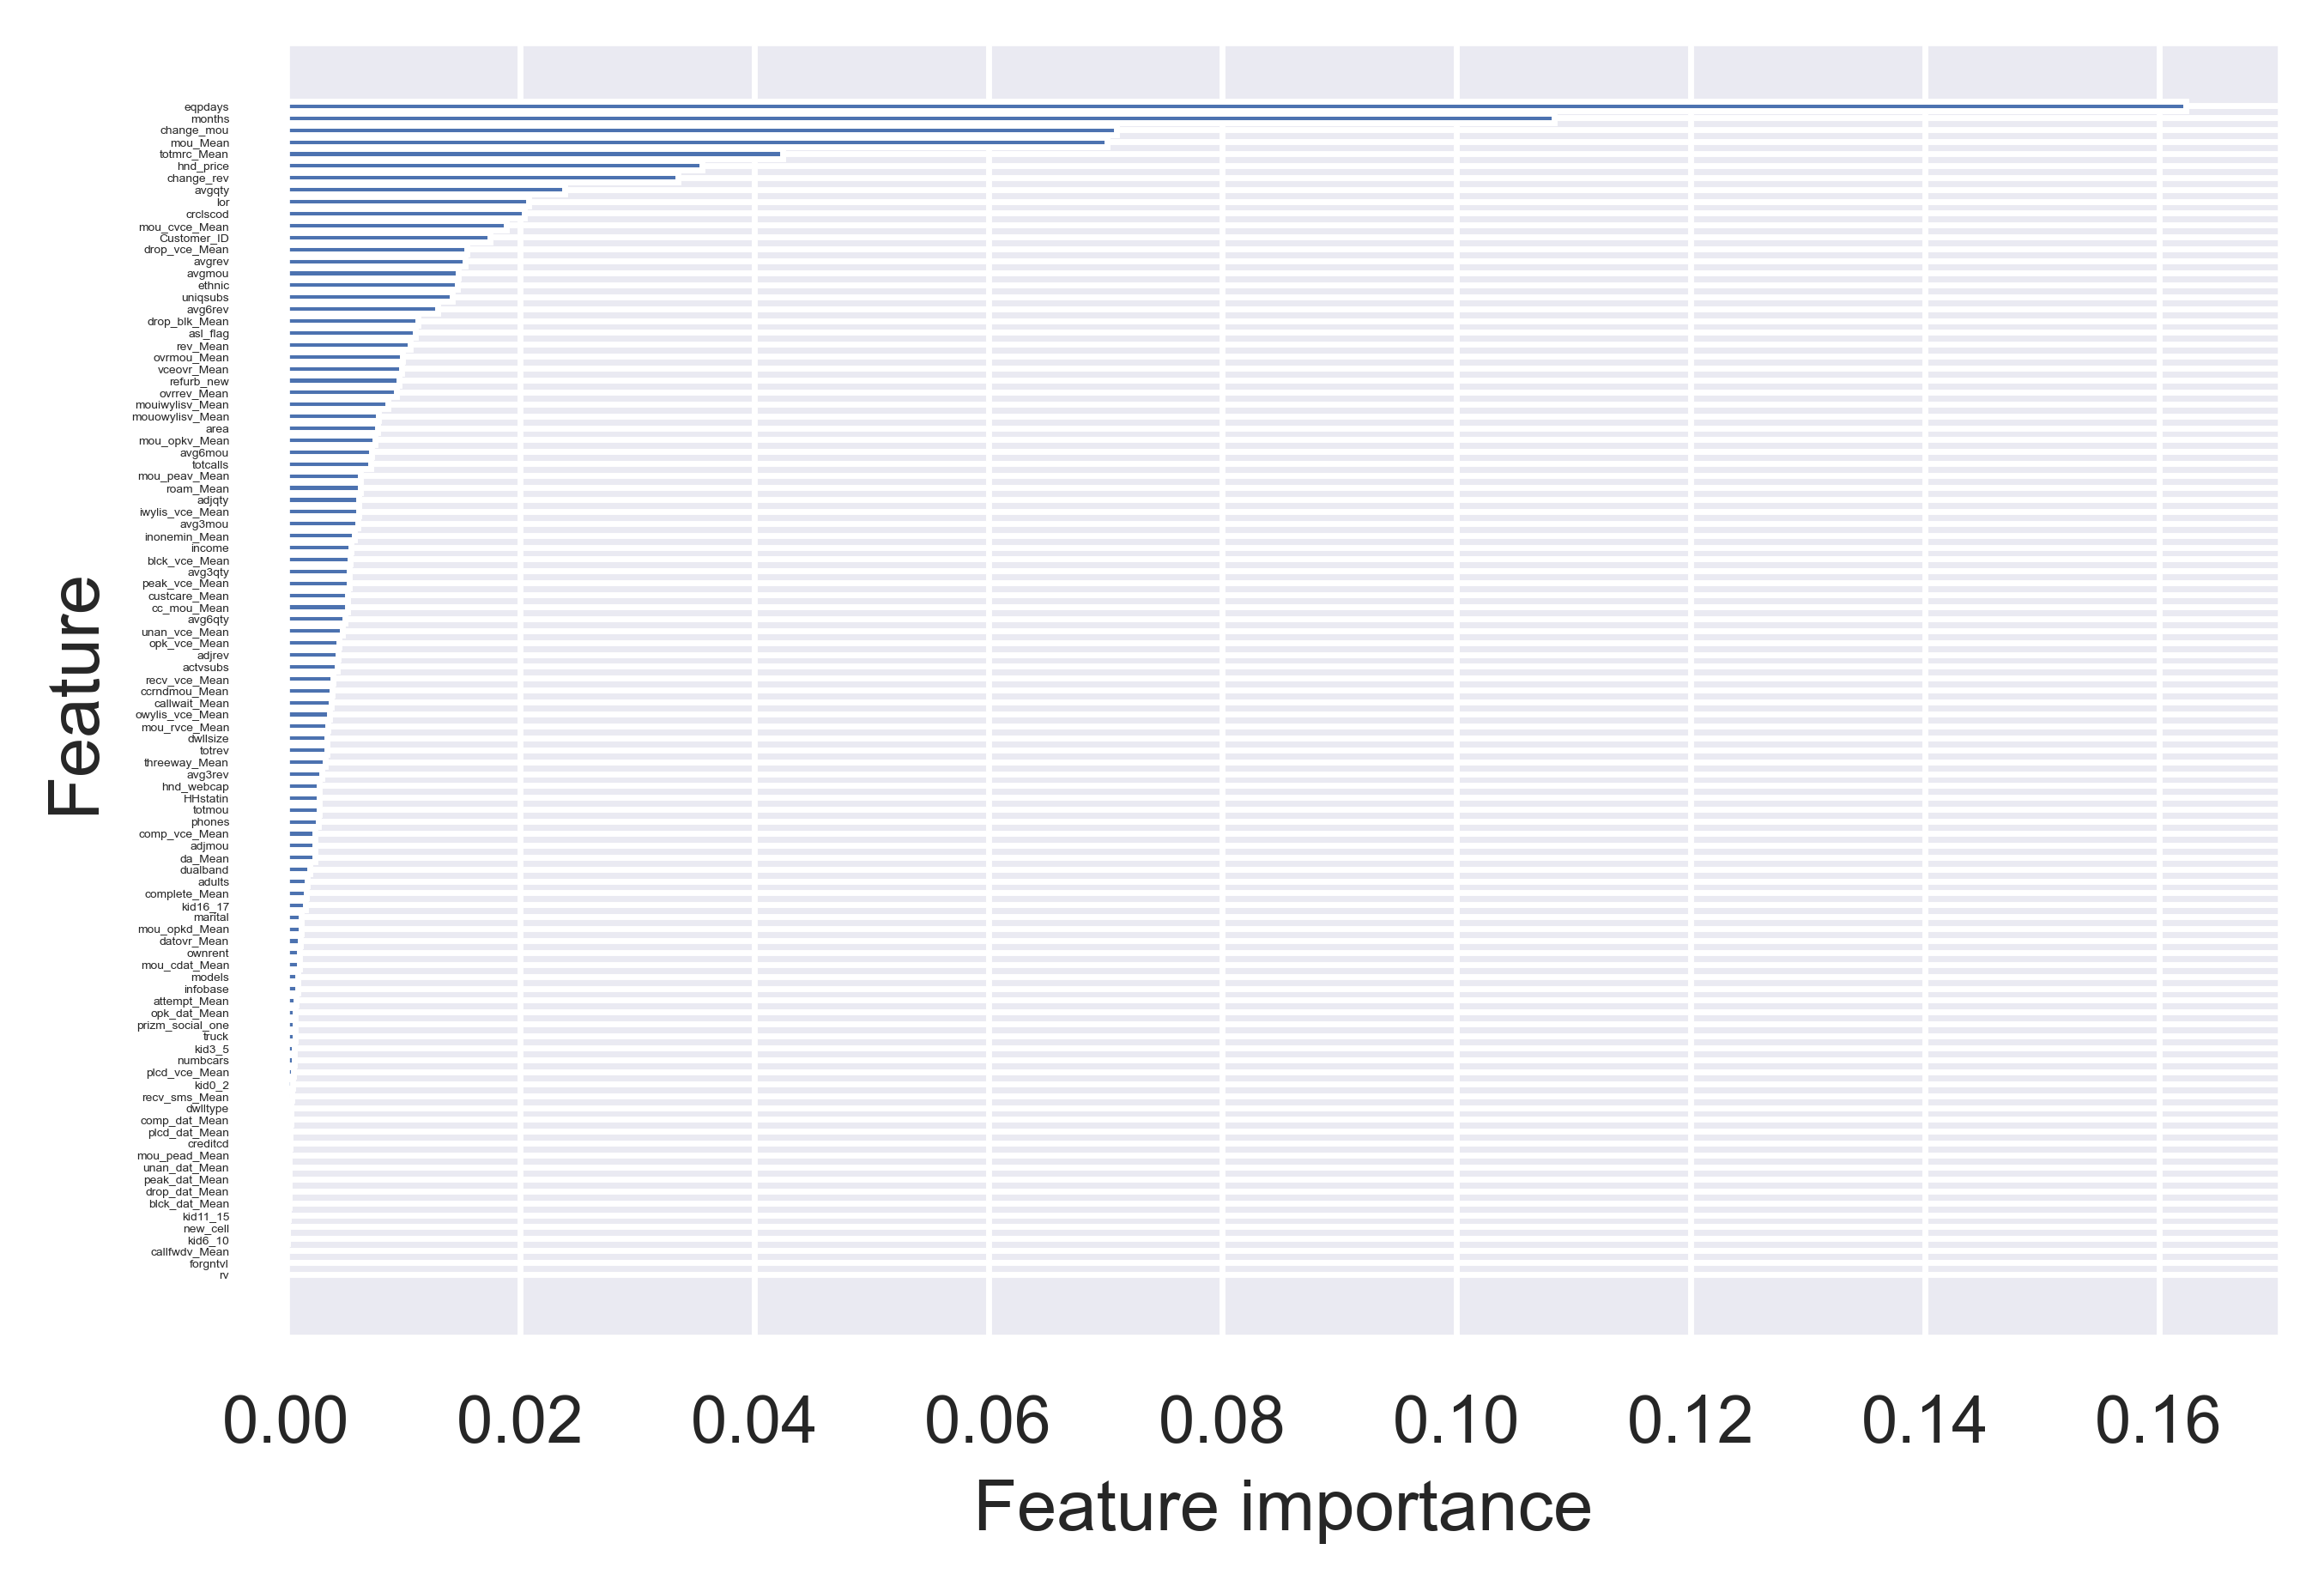

In [45]:
# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression', # 目的 : 回帰  
        'metric': {'suc'}, # 評価指標にはAUCを用いる
        
}

# モデルの学習
model = lgb.train(params,
                  train_set=lgb_train, # トレーニングデータの指定
                  valid_sets=lgb_eval, # 検証データの指定
                  )

# 特徴量重要度の算出 (データフレームで取得)
cols = list(data.drop('churn',axis=1).columns)       # 特徴量名のリスト(目的変数CRIM以外)
# 特徴量重要度の算出方法 'gain'(推奨) : トレーニングデータの損失の減少量を評価
f_importance = np.array(model.feature_importance(importance_type='gain')) # 特徴量重要度の算出
f_importance = f_importance / np.sum(f_importance) # 正規化
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # 降順ソート
plot_feature_importance(df_importance)

### LightGMBから得られた情報を観察してみる

In [46]:
# 解約率における契約　- eqpdays 現行機種の使用日数
data.groupby(["churn"])["eqpdays"].mean()

churn
0    363.280925
1    421.089524
Name: eqpdays, dtype: float64

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: eqpdays, dtype: object

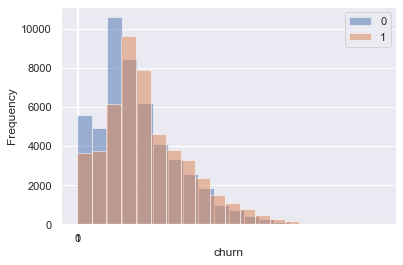

In [48]:
sns.barplot(x='churn', y='eqpdays', data=data, estimator=np.median)
data.groupby('churn')['eqpdays'].plot.hist(bins=20, alpha=0.5, legend=True)

In [49]:
# 有意差推定 -> ウィルコクソンの順位和検定
from scipy import stats
s, pvalue = stats.mannwhitneyu(data[data["churn"]==1]["eqpdays"]
                , data[data["churn"]==0]["eqpdays"]
                ,alternative='two-sided')
pvalue < 0.05

True

In [51]:
# 解約率　- months totalの利用月数
data.groupby(["churn"])["months"].mean()
data.groupby(["churn"])["months"].median()


churn
0    16
1    17
Name: months, dtype: int64

churn
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: months, dtype: object

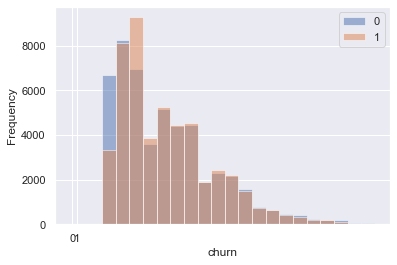

In [53]:
sns.barplot(x='churn', y='months', data=data, estimator=np.median)
data.groupby('churn')['months'].plot.hist(bins=20, alpha=0.5, legend=True)

In [54]:
# 有意差推定 -> ウィルコクソンの順位和検定
from scipy import stats
s, pvalue = stats.mannwhitneyu(data[data["churn"]==1]["months"]
                , data[data["churn"]==0]["months"]
                ,alternative='two-sided')
pvalue < 0.05

True